In [185]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.optim.lr_scheduler import StepLR

# Set random seed for reproducibility
# manualSeed = 999
manualSeed = random.randint(1, 10000) # random seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  2019


In [186]:
# Root directory for dataset
dataroot = "~/datasets/anime-faces"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Starting Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

lambda_ = 10

43102


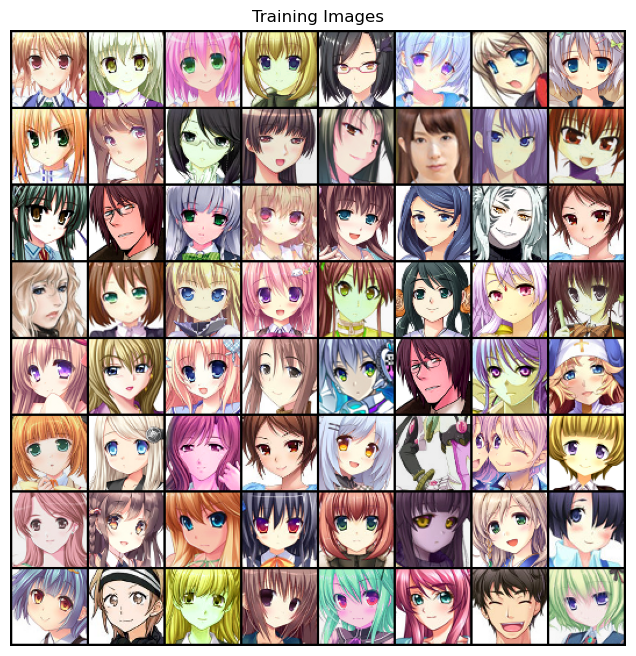

In [187]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
original_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
augmented_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               # adding some data augmentation
                               transforms.RandomHorizontalFlip(),
                               transforms.ColorJitter(contrast=0.2, saturation=0.2, hue=0.2),
                               #
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataset = torch.utils.data.ConcatDataset([original_dataset, augmented_dataset])
print(len(dataset))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [188]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [189]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [190]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [191]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten()
        )
        

    def forward(self, input):
        return self.main(input)

In [192]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

#Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
)


In [193]:
# Initialize the ``BCELoss`` function
# criterion = nn.BCELoss()
criterion = torch.nn.BCELoss()  # no sigmoid activation in the discriminator output

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = -1.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(beta1, 0.99))
optimizerG = optim.Adam(netG.parameters(), lr=0.0005, betas=(beta1, 0.99))

# Learning rate scheduler
scheduler_G = StepLR(optimizerG, step_size=2, gamma=0.8)
scheduler_D = StepLR(optimizerD, step_size=2, gamma=0.8)

In [194]:
# function for printing current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [195]:
def gradient_penalty(batch_size, real_images, fake_images):
    # each image in the set gets a random number (between 0 and 1) and is stored in alpha
    alpha = torch.randn(batch_size, 1, 1, 1, device=device)
    alpha = (alpha + 1) / 2
    # calculating interpolated images
    interpolated = real_images + alpha * (fake_images - real_images)

    interpolated = interpolated.requires_grad_(True)  # Enable gradient calculation
    pred = netD(interpolated).mean()
    # calculating gradient for interpolated images
    grad_output = torch.autograd.grad(outputs=pred, inputs=interpolated,
                                      create_graph=True, only_inputs=True,
                                      retain_graph=True)[0]
    grad_output = grad_output.view(grad_output.shape[0], -1)
    grad_norm = grad_output.norm(2, dim=1)
    gradient_penalty = (grad_norm - 1) ** 2
    # final result
    gp = gradient_penalty.mean()
    return gp

In [196]:
def gradient_penalty(discriminator, image_real, image_fake, device):
    t = torch.full(image_real.shape, np.random.rand(1)[0]).to(device)
    interpolation = t * image_real + (1 - t) * image_fake
    interpolation.requires_grad_()

    preds = discriminator(interpolation)
    grads = torch.autograd.grad(outputs=preds, inputs=interpolation,
                          grad_outputs=torch.ones_like(preds),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]

    gp = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()

    return gp

In [197]:
class WassersteinLoss(nn.Module):
    def __init__(self):
        super(WassersteinLoss, self).__init__()
        
    def forward(self, outputs, targets):
        return -torch.mean(targets * outputs)

In [198]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        # we need to first train the critic three times
        
        # resetting the gradients
        # netD.zero_grad()
        optimizerD.zero_grad()
        # getting real images
        real_images = data[0].to(device)
        # batch size
        b_size = real_images.size(0)
        # generating latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # generating fake images
        fake_images = netG(noise)

        # pass through the real data
        real_predictions = netD(real_images)
        real_targets = torch.ones(real_images.shape[0], 1, device=device)
        real_loss = WassersteinLoss.forward(netD, real_predictions, real_targets)
        # pass through the fake images           
        fake_predictions = netD(fake_images)
        fake_targets = -torch.ones(fake_images.shape[0], 1, device=device)
        fake_loss = WassersteinLoss.forward(netD, fake_predictions, fake_targets)    
            

        # calculating gradient penalty
        d_gp = gradient_penalty(netD, real_images, fake_images, device=device)
        # calculating Wasserstein loss
        d_loss = real_loss + fake_loss + 0.2 * d_gp
                
        d_loss.backward()
        optimizerD.step()    
        
        if (i % 5 == 0):
            optimizerG.zero_grad()
            # training the generator
            # generating latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # generating fake images
            fake_images = netG(noise)
            # pass through the fake images
            fake_predictions = netD(fake_images) 
            targets = torch.ones(real_images.shape[0], 1, device=device)
            # calculating loss for the generator
            g_loss = WassersteinLoss.forward(netG, fake_predictions, targets)
        
            g_loss.backward()
            optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                % (epoch, num_epochs, i, len(dataloader),
                    d_loss.item(), g_loss.item()))

        # Save Losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1
        
    '''if epoch != 0:
        scheduler_D.step()
        scheduler_G.step()
        # printing current learning rate
        current_d_lr = get_lr(optimizerD)
        current_g_lr = get_lr(optimizerG)
        print("######## D_lr = %.6f G_lr= %.6f ########" % (current_d_lr, current_g_lr))'''
        

Starting Training Loop...
[0/5][0/674]	Loss_D: 0.0103	Loss_G: 2.4929
[0/5][50/674]	Loss_D: -124.4580	Loss_G: 52.9020
[0/5][100/674]	Loss_D: -166.1478	Loss_G: 83.1919
[0/5][150/674]	Loss_D: -205.4521	Loss_G: 103.2108
[0/5][200/674]	Loss_D: -246.9134	Loss_G: 128.8286


KeyboardInterrupt: 

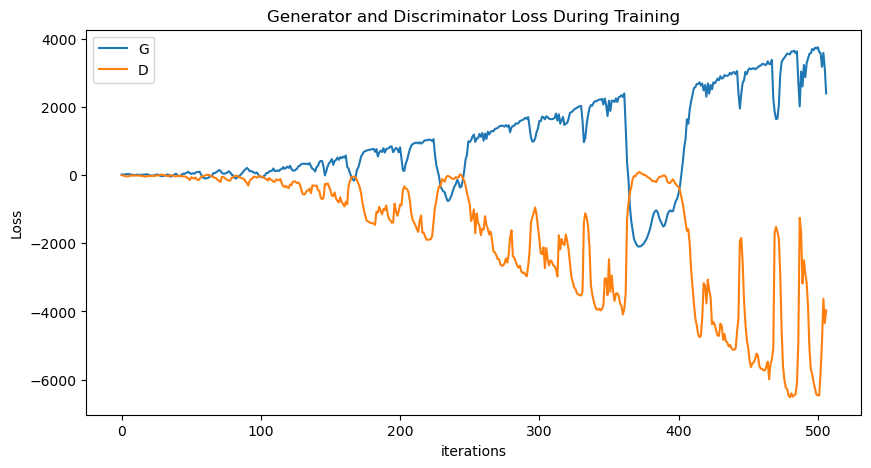

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

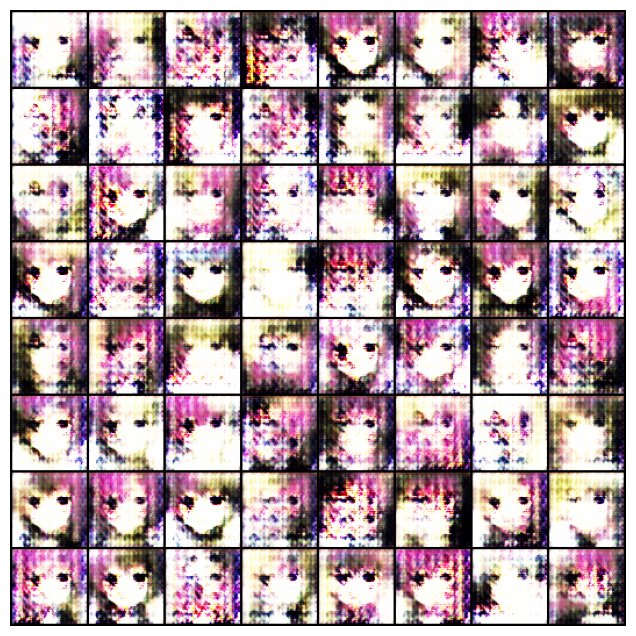

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())